Import all required modules

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.3 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 439 kB 60.4 MB/s 
     |████████████████████████████████| 6.0 MB 36.5 MB/s 
     |████████████████████████████████| 1.7 MB 62.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
from google.colab import drive
import keras
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from nltk.stem import WordNetLemmatizer 
import string
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

MOUNT THE DRIVE

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


READ TRAIN AND TEST DATA

In [ ]:


df = pd.read_csv("/content/gdrive/MyDrive/MachineLearning/disaster_tweets/train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/MachineLearning/disaster_tweets/test.csv")

df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


SEE PROPERTIES OF DATASET

In [ ]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
# Display number of samples for each class

df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.location.value_counts() 


USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [ ]:
df.groupby("target")["location"].value_counts()

target  location                                
0       New York                                    55
        USA                                         37
        London                                      29
        United States                               23
        Los Angeles, CA                             18
                                                    ..
1       ÌÏT: 40.562796,-75.488849                    1
        ÌÏT: 41.252426,-96.072013                    1
        ÌÏT: 6.4682,3.18287                          1
        ÌÏT: 6.488400524109015,3.352798039832285     1
        åø\_(?)_/åø                                  1
Name: location, Length: 3655, dtype: int64

In [ ]:


df.keyword.value_counts()


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:




df["keyword"] = df["keyword"].fillna(" ")
df_test["keyword"] = df["keyword"].fillna(" ")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("english"))

PREPROCESSING

In [ ]:
import nltk
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()

# def Standardization(text):
#   text = text.lower()
#   text = re.sub(r'@\w+', '', text)
#   text = re.sub(r'http:\S+', '', text)
#   text = re.sub(r'[^\w\s]', '', text)
#   text = [w for w in text.split() if w not in stop_words]
#   return " ".join(text)

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])


def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

def lemmatize(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_certain_numbers(text):
    return text.replace('20', ' ')



X = df.loc[:,"text"]
# Target Selection
y = df.loc[:,"target"]

#X1_test = df_test.loc[:,"text"]


X = X.apply(removeStopWords)
X = X.apply(removePunctuation)
X = X.apply(remove_certain_numbers)
X = X.apply(lemmatize)


# X1_test = X1_test.apply(removeStopWords)
# X1_test = X1_test.apply(removePunctuation)
# X1_test = X1_test.apply(remove_certain_numbers)
# X1_test = X1_test.apply(lemmatize)




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
X

0          our deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       all resident asked shelter place notified offi...
3       13000 people receive wildfire evacuation order...
4       just got sent photo ruby alaska smoke wildfire...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    ariaahrary thetawniest the control wild fire c...
7610    m194 0104 utc5km s volcano hawaii httptcozdtoy...
7611    police investigating ebike collided car little...
7612    the latest more home razed northern california...
Name: text, Length: 7613, dtype: object

CHECK MAX SEQUENCE LENGTH OF TWITTER TEXT

In [ ]:
def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len



max_seq_len = calculateMaxSeqLen(X)

print(max_seq_len)

27


SPLIT THE DATA IN TRAIN AND TEST

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=5
)




Vectorization (TextVectorization with max_tokens of 10000)


In [ ]:

text_vectorization = TextVectorization(
    output_mode="int",
   max_tokens=10000
)
text_vectorization.adapt(X)  

X_train = text_vectorization(X_train)
#x1_test = text_vectorization(X1_test)
X_test = text_vectorization(X_test)



In [ ]:
pickle.dump(text_vectorization.get_vocabulary(), open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/vocab.pkl', 'wb'))

Storing the X_train, X_test, Y_train, and Y_test for future use.

In [ ]:

pickle.dump(X_train, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/xtrain.pkl', 'wb'))
pickle.dump(X_test, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/xtest.pkl', 'wb'))
pickle.dump(y_train, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/ytrain.pkl', 'wb'))
pickle.dump(y_test, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/y_test.pkl', 'wb'))

In [ ]:

# X_train = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/xtrain.pkl', 'rb'))
# X_test = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/xtest.pkl', 'rb'))
# y_train=pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs', 'rb'))
# y_test=pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/ytest.pkl', 'rb'))

**Experiment-1: RNN with an embedding layer and two hidden layers (128,64, 32,16) to learn word embedding from the data, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
max_features = 10000
maxlen = 28

In [ ]:
# # Define model
# from keras.models import Sequential
# from keras.layers import Dense, CuDNNGRU
# from keras.optimizers import adam
# from keras.callbacks import ModelCheckpoint
# from __future__ import print_function
# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.optimizers import SGD
# from keras.constraints import maxnorm

# #cb = [ModelCheckpoint("model.hdf5", monitor='val_loss', save_weights_only=False, period=3)]

# def create_model():
#     # default values
    
#     optimizer='adam' # or SGD
#     lr = 0.01
#     momemntum=0
#     # create model
#     model = Sequential()
#     model.add(Dense(8, 
#                     input_dim=input_dim, kernel_initializer=init_mode, 
#                     activation=activation,
#                     kernel_constraint=maxnorm(weight_constraint)))
#     model.add(Dropout(dropout_rate)) 
#     model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='mae', 
#                   optimizer=optimizer, 
#                   metrics=['accuracy'])
#     return model

# # create model
# model = KerasClassifier(build_fn=create_model, batch_size=1000, epochs=10) 
# # use verbose=0 if you do not want to see progress

# ########################################################
# # Use scikit-learn to grid search 
 
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# ##############################################################
# # grid search epochs, batch size
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum , optimizer__optimizer = optimizer)
# ##############################################################
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train_scaled,y_train) 
# ##############################################################
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:

model = Sequential()
model.add(Embedding(max_features, maxlen))


model.add(SimpleRNN(32))
model.add(Dense(128, activation='relu' ))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split = 0.2
                   )



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 28)          280000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1952      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)               

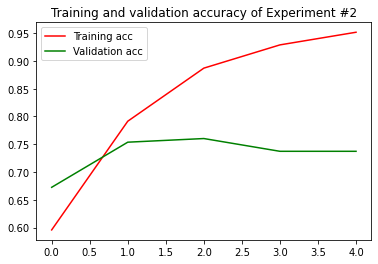

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #2')
plt.legend()

plt.figure()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
performanceArray = []



accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#1--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))




48/48 [==============================] - 0s 3ms/step
Experiment#1--> Accuracy:  0.7353906762967827  	Precision:  0.6765119549929677 	Recall:  0.735474006116208 	F1-Score:  0.7047619047619047


In [ ]:
# import tensorflow as tf

# y_pred = model.predict(x1_test)
# y_pred = tf.squeeze(tf.round(y_pred))
# y_pred

In [ ]:
# output = pd.DataFrame({'id':df_test['id'], 'text': df_test["text"]   , 'target': y_pred})
# output.to_csv("/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/RNN.csv", index=False)

In [ ]:
#output

**Experiment-2: RNN with an embedding layer and three hidden layers (128,64, 32,16) by Using Glove with 100d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D 

path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
model = Sequential()
model.add(Embedding(max_features, 100,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(SimpleRNN(32))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)               

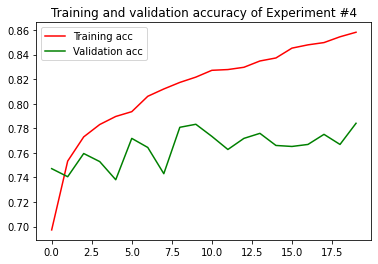

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #4')
plt.legend()

plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#2--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))


48/48 [==============================] - 0s 4ms/step
Experiment#2--> Accuracy:  0.8023637557452397  	Precision:  0.8413926499032882 	Recall:  0.6651376146788991 	F1-Score:  0.7429547395388556


In [ ]:
# Extract Vocabulary from drive
#vocabulary = pickle.load(open('drive/My Drive/Machine Learning/Assignment3/vocab.pkl', 'rb'))

FileNotFoundError: ignored

**Experiment-3: RNN with an embedding layer and three hidden layers (128, 64, 32,16) by Using Glove-twitter with 100d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/glove.twitter.27B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 100

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:

model = Sequential()
model.add(Embedding(10000, 100,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(SimpleRNN(32))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_12 (Dense)            (None, 128)               4224      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)               

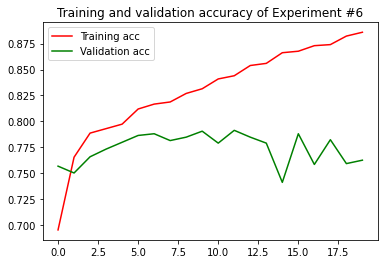

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #6')
plt.legend()

plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#6--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))

48/48 [==============================] - 0s 3ms/step
Experiment#6--> Accuracy:  0.7905449770190414  	Precision:  0.778702163061564 	Recall:  0.7155963302752294 	F1-Score:  0.7458167330677292


**Experiment-4: RNN with an embedding layer and three hidden layers (128,64, 32,16) by Using fastex with 300d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/wiki-news-300d-1M.vec"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 300

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(10000, 300,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(SimpleRNN(32))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=9,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         3000000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                10656     
                                                                 
 dense_17 (Dense)            (None, 128)               4224      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)               

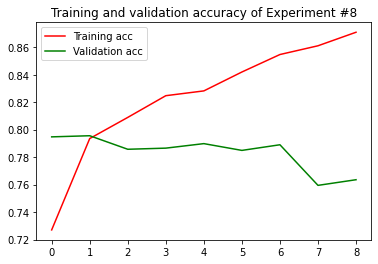

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #8')
plt.legend()

plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#8--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))

48/48 [==============================] - 0s 3ms/step
Experiment#8--> Accuracy:  0.7590282337491793  	Precision:  0.713859910581222 	Recall:  0.7324159021406728 	F1-Score:  0.7230188679245283


Now Moving to LSTM

**Experiment-5: LSTM with an embedding layer and three hidden layers (128, 64, 32,16) to learn word embedding from the data, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
max_features = 10000  # number of words to consider as features
maxlen = 28  # Cut texts after this number of words (among top max_features most common words)

model = Sequential()
model.add(Embedding(max_features, maxlen))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 28)          280000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               15616     
 l)                                                              
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                      

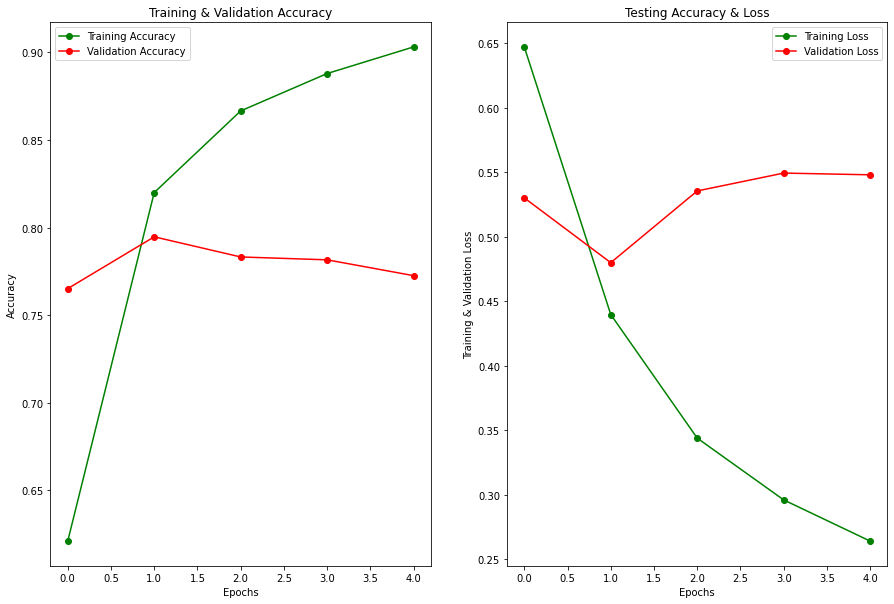

In [ ]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(15,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#8--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))

48/48 [==============================] - 1s 3ms/step
Experiment#8--> Accuracy:  0.7787261982928431  	Precision:  0.7168262653898769 	Recall:  0.8012232415902141 	F1-Score:  0.7566787003610108


In [ ]:
#vocabulary = pickle.load(open('drive/My Drive/Machine Learning/Assignment3/vocab.pkl','rb'))

FileNotFoundError: ignored

**Experiment-6: RNN with an embedding layer and three hidden layers (128,64, 32,16) by Using Glove with 100d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:

path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 100

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(max_features, 100,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(Bidirectional(LSTM(32)))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 128)               8320      
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                      

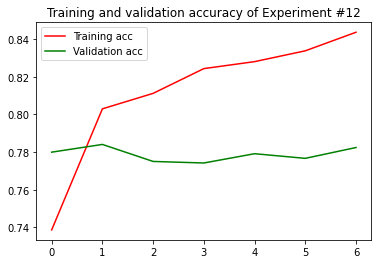

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #12')
plt.legend()

plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#12--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))


48/48 [==============================] - 1s 3ms/step
Experiment#12--> Accuracy:  0.8017071569271176  	Precision:  0.7682926829268293 	Recall:  0.7706422018348624 	F1-Score:  0.7694656488549618


In [ ]:
# Extract Vocabulary from drive
#vocabulary = pickle.load(open('drive/My Drive/Machine Learning/Assignment3/vocab.pkl', 'rb'))

**Experiment-7: LSTM with an embedding layer and two hidden layers (128,64,32,16) by Using Glove-twitter with 100d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/glove.twitter.27B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 100

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:


model = Sequential()
model.add(Embedding(10000, 100,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(Bidirectional(LSTM(32)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                      

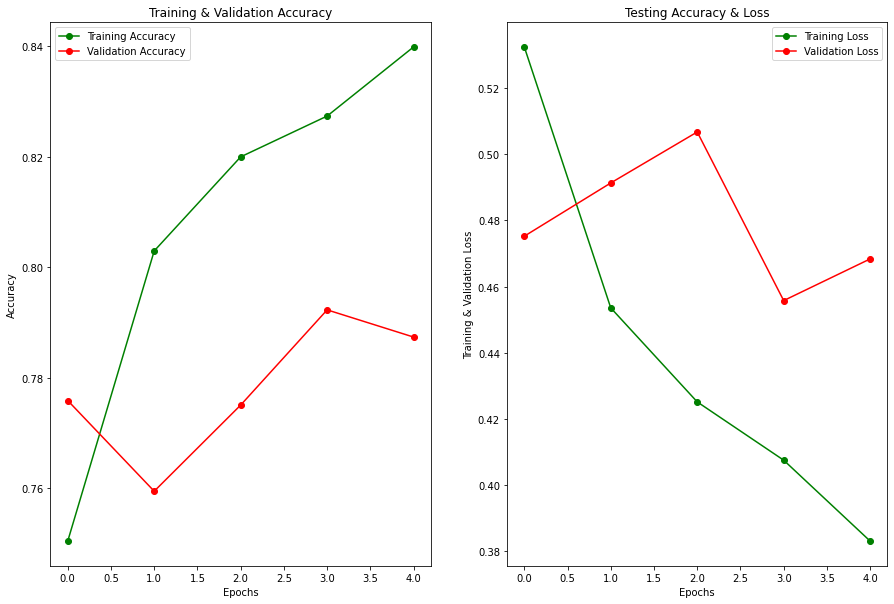

In [ ]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(15,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#13--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))

48/48 [==============================] - 1s 3ms/step
Experiment#13--> Accuracy:  0.8161523309258043  	Precision:  0.8303886925795053 	Recall:  0.7186544342507645 	F1-Score:  0.7704918032786885


In [ ]:
#vocabulary = pickle.load(open('drive/My Drive/Machine Learning/Assignment3/vocab.pkl','rb'))

FileNotFoundError: ignored

**Experiment-8: LSTM with an embedding layer and two hidden layers (128,64, 32,16) by Using fastex with 300d, keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
path_to_glove_file = "/content/gdrive/MyDrive/MachineLearning/disaster_tweets/wiki-news-300d-1M.vec"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 300

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i <10000:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:

model = Sequential()
model.add(Embedding(10000, 300,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,))

model.add(Bidirectional(LSTM(32)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                      

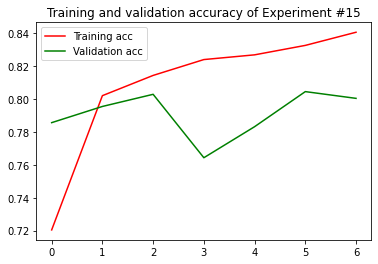

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #15')
plt.legend()

plt.figure()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))

accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#15--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))

48/48 [==============================] - 1s 3ms/step
Experiment#15--> Accuracy:  0.814182534471438  	Precision:  0.8128161888701517 	Recall:  0.7370030581039755 	F1-Score:  0.7730553327987169


Summary

In [ ]:
# result = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl','rb'))

# description = ["Eperiment# 1:  RNN with two Hidden Layers and word embedding from data","Eperiment# 2:  RNN with three Hidden Layers and word embedding from data","Eperiment# 3:  RNN with two Hidden Layers and pre-trained Glove word embedding","Eperiment# 4:  RNN with three Hidden Layers and pre-trained Glove word embedding","Eperiment# 5:  RNN with two Hidden Layer and pre-trained Glove-Twitter word embedding","Eperiment# 6:  RNN with three Hidden Layer and pre-trained Glove-Twitter word embedding","Eperiment# 7:  RNN with two Hidden Layer and pre-trained fastText word embedding","Eperiment# 8:  RNN with three Hidden Layer and pre-trained fastText word embedding"]

# accuracy = []
# precision= []
# recall=[]
# f1=[]

# for i in range(8):
#     accuracy.append(result[i][0])
#     precision.append(result[i][1])
#     recall.append(result[i][2])
#     f1.append(result[i][2])
   


In [ ]:
# data = {'Experiment Description': description, 'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1 }  

# df = pd.DataFrame(data)

In [ ]:
# df

***Out of my 16 experiments , Eperiment# 10: LSTM with three Hidden Layers and word embedding from data performs better has best performance than others beacuse it has good accuracy, precision, recall, and F1-Score.***



WORKING ON BERT


**Experiment-9: keeping max feature size = 10000 and max length of each tweet 28 words**

In [ ]:
!pip install tensorflow-text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.6 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 1.7 MB 54.9 MB/s 
     |████████████████████████████████| 6.0 MB 64.2 MB/s 
     |████████████████████████████████| 439 kB 69.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

preprocess bert library and and uncased bert embeddings

In [ ]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [ ]:

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)
d_layer = tf.keras.layers.Dense(128, name="dense-layer1")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dropout(0.2, name="dropout-layer1")(d_layer)
d_layer = tf.keras.layers.Dense(64, name="dense-layer2")(d_layer)
d_layer = tf.keras.layers.Dropout(0.2, name="dropout-layer2")(d_layer)
d_layer = tf.keras.layers.Dense(32, name="dense-layer3")(d_layer)
d_layer = tf.keras.layers.Dropout(0.2, name="dropout-layer3")(d_layer)
d_layer = tf.keras.layers.Dense(16, name="dense-layer4")(d_layer)
d_layer = tf.keras.layers.Dropout(0.2, name="dropout-layer4")(d_layer)
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text-layer[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=4,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_split = 0.2)


Epoch 1/50
39/39 [==============================] - 96s 2s/step - loss: 1.1642 - acc: 0.5593 - val_loss: 0.8033 - val_acc: 0.5739
Epoch 2/50
39/39 [==============================] - 82s 2s/step - loss: 0.7415 - acc: 0.5899 - val_loss: 0.6149 - val_acc: 0.6404
Epoch 3/50
39/39 [==============================] - 81s 2s/step - loss: 0.7084 - acc: 0.6106 - val_loss: 1.0873 - val_acc: 0.4278
Epoch 4/50
39/39 [==============================] - 82s 2s/step - loss: 0.6820 - acc: 0.6326 - val_loss: 0.7166 - val_acc: 0.5862
Epoch 5/50
39/39 [==============================] - 81s 2s/step - loss: 0.6747 - acc: 0.6332 - val_loss: 0.6397 - val_acc: 0.6470
Epoch 6/50
39/39 [==============================] - 81s 2s/step - loss: 0.6546 - acc: 0.6418 - val_loss: 0.5875 - val_acc: 0.6938
Epoch 7/50
39/39 [==============================] - 84s 2s/step - loss: 0.6385 - acc: 0.6595 - val_loss: 0.5842 - val_acc: 0.6970
Epoch 8/50
39/39 [==============================] - 81s 2s/step - loss: 0.6260 - acc: 0.67

In [ ]:
print(tf. __version__)

2.11.0


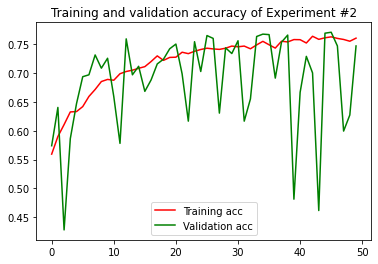

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy of Experiment #2')
plt.legend()

plt.figure()
plt.show()


In [ ]:
y_pred = model.predict(X_test)

performanceArray = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'rb'))



accuracy = accuracy_score(y_test,y_pred.round())
precision = precision_score(y_test,y_pred.round())
recall=recall_score(y_test,y_pred.round())
f1 = f1_score(y_test,y_pred.round())
performanceArray.append([accuracy,precision,recall,f1])
print('Experiment#1--> Accuracy: ',accuracy,' \tPrecision: ',precision,'\tRecall: ',recall,'\tF1-Score: ',f1)

# In order to store the performance( accuracy, precision, recall and F1) of each experiment 
pickle.dump(performanceArray, open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl', 'wb'))




48/48 [==============================] - 16s 314ms/step
Experiment#1--> Accuracy:  0.7715036112934996  	Precision:  0.8923076923076924 	Recall:  0.5321100917431193 	F1-Score:  0.6666666666666666


SUMMARY

In [ ]:
result = pickle.load(open('/content/gdrive/MyDrive/MachineLearning/disaster_tweets/outputs/performance.pkl','rb'))

description = ["Eperiment# 1:  Simple RNN","Eperiment# 2: RNN and pre-trained Glove word embedding" ,"Eperiment# 3:  RNN with  and pre-trained twitter Glove word embedding","Eperiment# 4:  RNN and pre-trained FastText word embedding","Eperiment# 5: Simple LSTM  ","Eperiment# 6: LSTM and pre-trained Glove word embedding  ","Eperiment# 7: LSTM and pre-trained twitter-Glove word embedding  ","Eperiment# 8: LSTM and pre-trained FastText word embedding ", "Eperiment# 9: BERT "]

accuracy = []
precision= []
recall=[]
f1=[]

for i in range(9):
    accuracy.append(result[i][0])
    precision.append(result[i][1])
    recall.append(result[i][2])
    f1.append(result[i][2])
   


In [ ]:
data = {'Experiment Description': description, 'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1 }  

df1 = pd.DataFrame(data)

In [ ]:
df1

,Experiment Description,Accuracy,Precision,Recall,F1-Score
0,Eperiment# 1: Simple RNN,0.735391,0.676512,0.735474,0.735474
1,Eperiment# 2: RNN and pre-trained Glove word e...,0.802364,0.841393,0.665138,0.665138
2,Eperiment# 3: RNN with and pre-trained twitt...,0.790545,0.778702,0.715596,0.715596
3,Eperiment# 4: RNN and pre-trained FastText wo...,0.759028,0.713860,0.732416,0.732416
4,Eperiment# 5: Simple LSTM,0.778726,0.716826,0.801223,0.801223
5,Eperiment# 6: LSTM and pre-trained Glove word ...,0.801707,0.768293,0.770642,0.770642
6,Eperiment# 7: LSTM and pre-trained twitter-Glo...,0.816152,0.830389,0.718654,0.718654
7,Eperiment# 8: LSTM and pre-trained FastText wo...,0.814183,0.812816,0.737003,0.737003
8,Eperiment# 9: BERT,0.771504,0.892308,0.532110,0.532110
